### TODOs
[ ] Load SAM3 as a model
[ ] Gemini / OpenAI API support

In [36]:
# Go to sam3 root dir
%cd ~/code/sam3

/storage/home/jialez/code/sam3


In [38]:
# Start SAM3 server

SAM3_SERVICE_URL = "http://h200-235-192:8000/segment"


In [37]:
LLM_CONFIGS = {
    # VLLM-served models
    "qwen2.5_7b": {
        "provider": "vllm",
        "model": "Qwen/Qwen2.5-VL-7B-Instruct",
    },
    "qwen2.5_72b": {
        "provider": "vllm",
        "model": "Qwen/Qwen2.5-VL-72B-Instruct",
    },
    "llama4_maverick": {
        "provider": "vllm",
        "model": "meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8",
    },
    "llama4_scout": {
        "provider": "vllm",
        "model": "meta-llama/Llama-4-Scout-17B-16E-Instruct",
    },
    "gpt5": {
        "provider": "openai",
        "base_url": "https://api.openai.com/v1/",
        "model": "gpt-5",
    },
    "gemini_pro": {
        "provider": "gemini",
        "base_url": "https://generativelanguage.googleapis.com/v1beta/",
        "model": "gemini-2.5-pro",
    },
    "gemini_flash": {
        "provider": "gemini",
        "base_url": "https://generativelanguage.googleapis.com/v1beta/",
        "model": "gemini-2.5-flash",
    }
}

model = "qwen2.5_7b" # @param ["qwen2.5_7b,"qwen2.5_72b","llama4_maverick","llama4_scout","gpt5","gemini_pro","gemini_flash"] {"allow-input":true}
LLM_API_KEY = "DUMMY_API_KEY" # @param ["DUMMY_API_KEY"]

#model = "gpt5"
#LLM_API_KEY = "YOUR_OPENAI_API_KEY"

#model = "gemini_pro"
#LLM_API_KEY = "YOUR_GEMINI_API_KEY"


llm_config = LLM_CONFIGS[model]
llm_config["api_key"] = LLM_API_KEY
llm_config["name"] = model

In [39]:
# Start LLM server, skip this step if you are calling LLM using an API

# qwen 2.5VL 7B
# vllm serve Qwen/Qwen2.5-VL-7B-Instruct --tensor-parallel-size 1 --allowed-local-media-path / --enforce-eager --port 8001

# qwen 2.5VL 72B
#vllm serve Qwen/Qwen2.5-VL-72B-Instruct --tensor-parallel-size 8 --allowed-local-media-path / --enforce-eager --port 8001

# Llama 4 Maverick
# VLLM_DISABLE_COMPILE_CACHE=1 vllm serve meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8   --tensor-parallel-size 8   --max-model-len 430000 --allowed-local-media-path / --port 8001

# Llama 4 Scout
# VLLM_DISABLE_COMPILE_CACHE=1 vllm serve meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8   --tensor-parallel-size 4   --max-model-len 30000 --allowed-local-media-path / --max-num-seqs 1 --port 8001

if llm_config["provider"] == "vllm":
    #LLM_SERVER_URL = "http://localhost:8001/v1"
    LLM_SERVER_URL = "http://h200-126-061:8001/v1" # TODO replace this with default LLM url
else:
    LLM_SERVER_URL = llm_config["base_url"]


In [40]:
# Import dependencies
import os
import json
from functools import partial


from sam3.agent.agent_core import agent_inference
from sam3.agent.client_llm import send_generate_request as send_generate_request_orig
from sam3.agent.client_sam3 import call_sam_service as call_sam_service_orig

In [41]:
def run_single_image_inference(image_path, text_prompt, llm_config, send_generate_request, call_sam_service, output_dir="agent_output"):
    """Run inference on a single image with provided prompt"""

    llm_name = llm_config["name"]

    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image file not found: {image_path}")

    # Create output directory
    os.makedirs(output_dir, exist_ok=True)

    # Generate output file names
    image_basename = os.path.splitext(os.path.basename(image_path))[0]
    prompt_for_filename = text_prompt.replace("/", "_").replace(" ", "_")

    base_filename = f"{image_basename}_{prompt_for_filename}_Agent_{llm_name}"
    output_json_path = os.path.join(output_dir, f"{base_filename}_Pred.json")
    output_image_path = os.path.join(output_dir, f"{base_filename}_Pred.png")
    agent_history_path = os.path.join(output_dir, f"{base_filename}_History.json")

    # Check if output already exists and skip
    if os.path.exists(output_json_path):
        print(f"Output JSON {output_json_path} already exists. Skipping.")
        return

    print(f"\n\n\n--------------Processing single image with prompt: {text_prompt}--------------\n")
    print(f"Image: {image_path}")
    print(f"Output directory: {output_dir}")

    #try:
    agent_history, final_output_dict, rendered_final_output = agent_inference(
        image_path, text_prompt,
        send_generate_request=send_generate_request,
        call_sam_service=call_sam_service
    )

    final_output_dict["text_prompt"] = text_prompt
    final_output_dict["image_path"] = image_path

    # Save outputs
    json.dump(final_output_dict, open(output_json_path, 'w'), indent=4)
    json.dump(agent_history, open(agent_history_path, 'w'), indent=4)
    rendered_final_output.save(output_image_path)

    print(f"\n✅ Successfully processed single image!")
    print(f"Output JSON: {output_json_path}")
    print(f"Output Image: {output_image_path}")
    print(f"Agent History: {agent_history_path}")




--------------Processing single image with prompt: People wearing blue clothes--------------

Image: /storage/home/jialez/code/sam3/assets/images/test_image.jpg
Output directory: agent_output

Initial text prompt:

 People wearing blue clothes


Initial image path:

 /storage/home/jialez/code/sam3/assets/images/test_image.jpg
image_path /storage/home/jialez/code/sam3/assets/images/test_image.jpg
processed_messages: [{'role': 'system', 'content': 'You are a helpful visual-concept grounding assistant capable of leveraging tool calls to ground concepts the user refers to, and providing structured JSON outputs and tool calls.\nThe user may provide you with a referring expression that matches some part(s) of the image, or a question whose answer points to some part(s) of the image.\nYou should observe and analyze the image along with the initial user input query very carefully, note all details in the image, think about what the user is actually referring to, how to leverage existing too
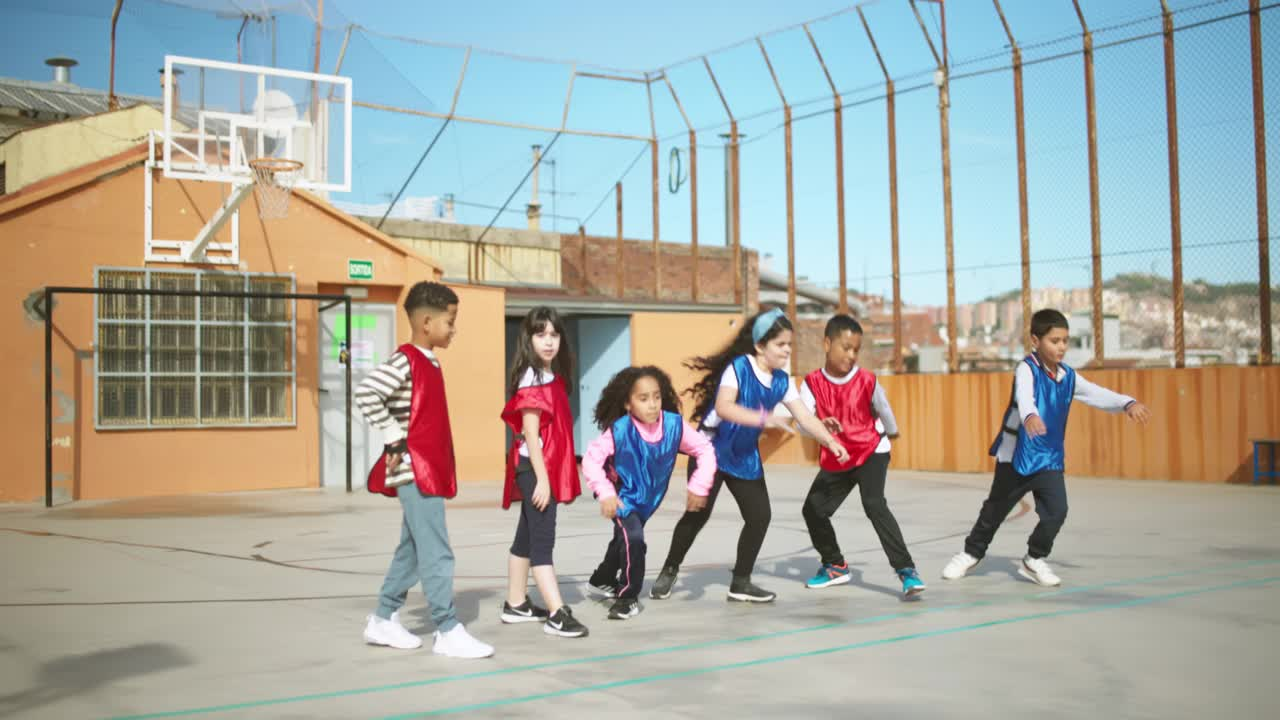

findfont: Generic family 'sans-serif' not found because none of the following families were found: Liberation Sans, Bitstream Vera Sans, Noto Sans TC, Noto Sans SC, Noto Sans Thai, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif, Noto Naskh Arabic UI, Noto Sans UI


findfont: Generic family 'sans-serif' not found because none of the following families were found: Liberation Sans, Bitstream Vera Sans, Noto Sans TC, Noto Sans SC, Noto Sans Thai, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif, Noto Naskh Arabic UI, Noto Sans UI


findfont: Generic family 'sans-serif' not found because none of the following families were found: Liberation Sans, Bitstream Vera Sans, Noto Sans TC, Noto Sans SC, Noto Sans Thai, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif, Noto Naskh Arabic UI, Noto Sans UI


findfont: Generic family 'sans-serif' not found because none of the following families were found: Liberation Sans, Bitstream Vera Sans, Noto Sans TC, Noto Sans SC, Noto Sans Thai, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif, Noto Naskh Arabic UI, Noto Sans UI


findfont: Generic family 'sans-serif' not found because none of the following families were found: Liberation Sans, Bitstream Vera Sans, Noto Sans TC, Noto Sans SC, Noto Sans Thai, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif, Noto Naskh Arabic UI, Noto Sans UI


findfont: Generic family 'sans-serif' not found because none of the following families were found: Liberation Sans, Bitstream Vera Sans, Noto Sans TC, Noto Sans SC, Noto Sans Thai, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif, Noto Naskh Arabic UI, Noto Sans UI


findfont: Generic family 'sans-serif' not found because none of the following families were found: Liberation Sans, Bitstream Vera Sans, Noto Sans TC, Noto Sans SC, Noto Sans Thai, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif, Noto Naskh Arabic UI, Noto Sans UI


✅ Saved visualization at: /checkpoint/sam3/jialez//code/out/sam_out/-storage-home-jialez-code-sam3-assets-images-test_image.jpg/people wearing blue clothes.png


sam3_output_text_message:
 The segment_phrase tool generated 3 available masks. All 3 available masks are rendered in this image below, now you must analyze the 3 available mask(s) carefully, compare them against the raw input image and the original user query, and determine your next action. Please be reminded that the original user query was 'People wearing blue clothes'.
image_path /storage/home/jialez/code/sam3/assets/images/test_image.jpg
image_path /checkpoint/sam3/jialez//code/out/sam_out/-storage-home-jialez-code-sam3-assets-images-test_image.jpg/people wearing blue clothes.png
processed_messages: [{'role': 'system', 'content': 'You are a helpful visual-concept grounding assistant capable of leveraging tool calls to ground concepts the user refers to, and providing structured JSON outputs and tool calls.\nThe user may 
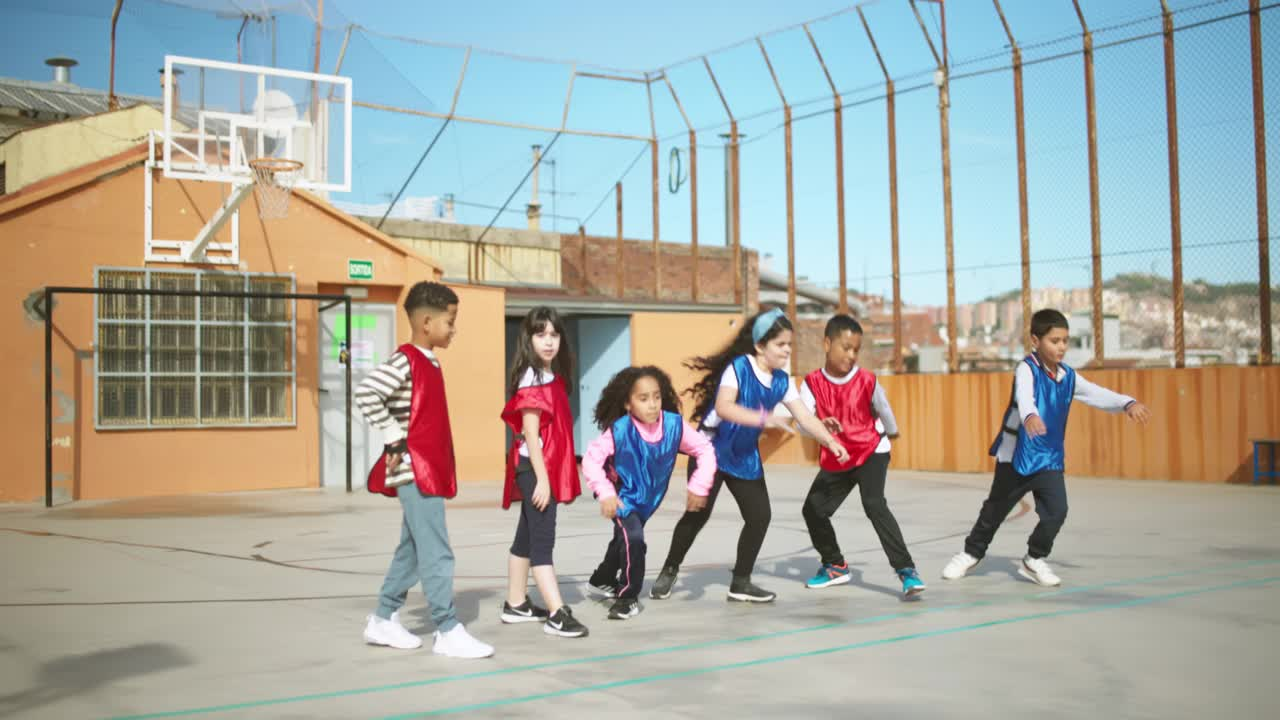
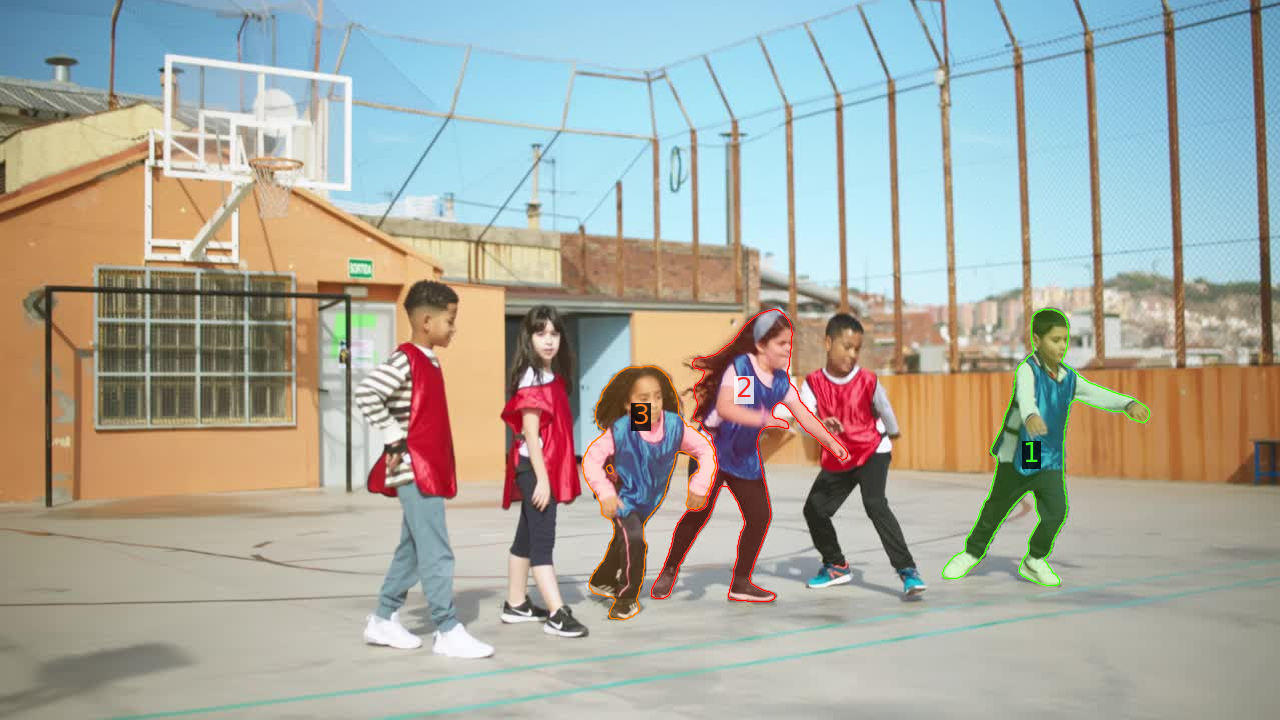

findfont: Generic family 'sans-serif' not found because none of the following families were found: Liberation Sans, Bitstream Vera Sans, Noto Sans TC, Noto Sans SC, Noto Sans Thai, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif, Noto Naskh Arabic UI, Noto Sans UI


findfont: Generic family 'sans-serif' not found because none of the following families were found: Liberation Sans, Bitstream Vera Sans, Noto Sans TC, Noto Sans SC, Noto Sans Thai, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif, Noto Naskh Arabic UI, Noto Sans UI


findfont: Generic family 'sans-serif' not found because none of the following families were found: Liberation Sans, Bitstream Vera Sans, Noto Sans TC, Noto Sans SC, Noto Sans Thai, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif, Noto Naskh Arabic UI, Noto Sans UI


findfont: Generic family 'sans-serif' not found because none of the following families were found: Liberation Sans, Bitstream Vera Sans, Noto Sans TC, Noto Sans SC, Noto Sans Thai, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif, Noto Naskh Arabic UI, Noto Sans UI


findfont: Generic family 'sans-serif' not found because none of the following families were found: Liberation Sans, Bitstream Vera Sans, Noto Sans TC, Noto Sans SC, Noto Sans Thai, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif, Noto Naskh Arabic UI, Noto Sans UI


Received response: ChatCompletionMessage(content='<think>I have analyzed the 3 available masks generated by the segment_phrase tool. Mask 1 is green and does not correspond to anyone wearing blue clothes. Mask 2 is orange and corresponds to a child wearing a blue shirt. Mask 3 is red and corresponds to a child wearing a blue shirt. Both masks 2 and 3 match the user query "People wearing blue clothes". \n\nSince the user query is clear and the masks accurately represent the target, I can proceed to finalize the selection of the correct masks.\n\n</think>\n<tool> {"name": "select_masks_and_return", "parameters": {"final_answer_masks": [2, 3]}} </tool>', refusal=None, role='assistant', annotations=None, audio=None, function_call=None, tool_calls=[], reasoning_content=None)


 Generated_text:

 <think>I have analyzed the 3 available masks generated by the segment_phrase tool. Mask 1 is green and does not correspond to anyone wearing blue clothes. Mask 2 is orange and corresponds to a child


✅ Successfully processed single image!
Output JSON: agent_output/test_image_People_wearing_blue_clothes_Agent_qwen2.5_7b_Pred.json
Output Image: agent_output/test_image_People_wearing_blue_clothes_Agent_qwen2.5_7b_Pred.png
Agent History: agent_output/test_image_People_wearing_blue_clothes_Agent_qwen2.5_7b_History.json


In [42]:
image = "assets/images/test_image.jpg"
prompt = "People wearing blue clothes"

# get absolute path for image
image = os.path.abspath(image)
send_generate_request = partial(send_generate_request_orig, server_url=LLM_SERVER_URL, model=llm_config["model"], api_key=llm_config["api_key"])
call_sam_service = partial(call_sam_service_orig, server_url=SAM3_SERVICE_URL)

# Run single image inference
run_single_image_inference(image, prompt, llm_config, send_generate_request, call_sam_service)